# Notebook to explore the MIT-BIH Arrhythmia Dataset

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scripts.load_data import download_mitbih, load_record
from scripts.plotting import plot_label_distribution, plot_frequency_spectrum, plot_ecg_segment
from scripts.preprocess import segment_beats, bandpass_filter, notch_filter, normalize

# Download and load record 100
download_mitbih(records = ["100"])
data = load_record("100")

signal = data["signal"]
annotations = data["annotations"]
fs = data["fs"]  #sampling frequency

print(f"Signal shape: {signal.shape}")
print(f"Sampling frequency: {fs} Hz")
print(f"Number of annotations: {len(annotations['symbols'])}")

Generating record list for: 100
Generating list of all files for: 100
Finished downloading files
Signal shape: (650000, 2)
Sampling frequency: 360 Hz
Number of annotations: 2274


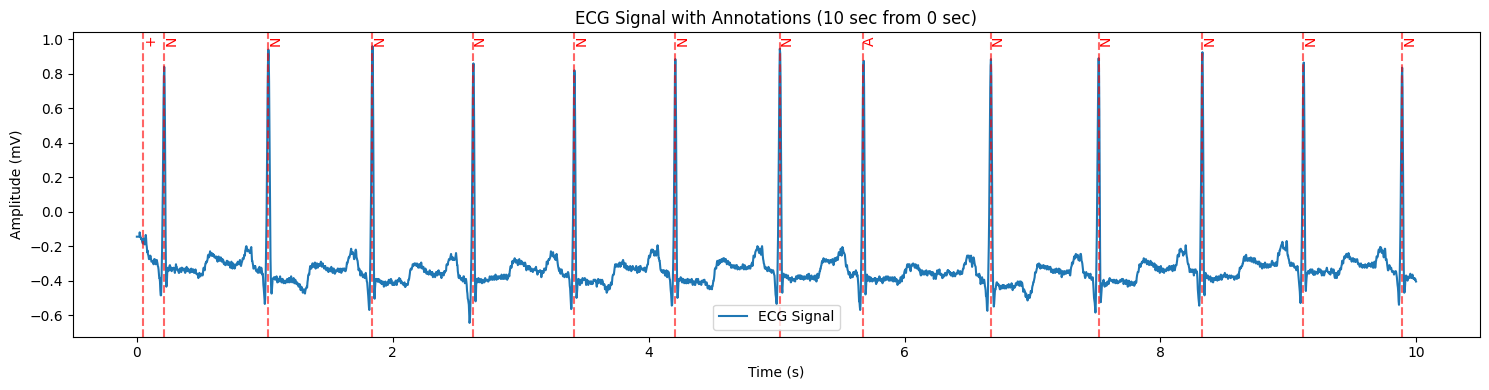

In [2]:
# Plot a segment of the ECG signal with annotations
plot_ecg_segment(signal, annotations, fs, start_sec = 0, duration_sec = 10)

In [3]:
# Annotation symbol summary
symbol_counts = Counter(annotations["symbols"])
print("Annotation Symbol Frequencies:")
for sym, count in symbol_counts.items():
    print(f"{sym}: {count}")

Annotation Symbol Frequencies:
+: 1
N: 2239
A: 33
V: 1


## Preprocess the Data and Check the Frequency Spectrum

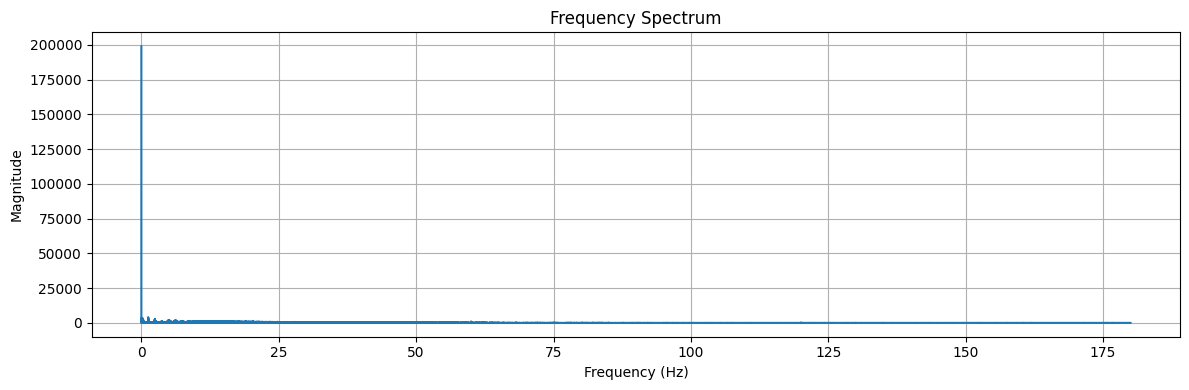

In [4]:
# check the frequcncy content before filtering
plot_frequency_spectrum(signal, fs, max_freq = 1000, channel = 0)

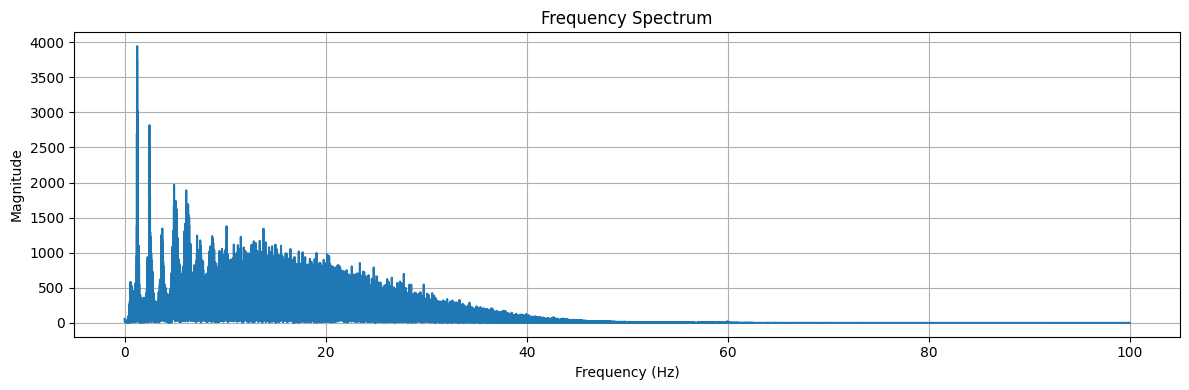

In [5]:
# Apply bandpass
filtered = bandpass_filter(signal, fs, 0.5, 40)

# Apply notch filter if 60 Hz interference is observed in spectrum
#filtered = notch_filter(filtered, fs, freq = 60.0)

# Normalize for modeling
normalized = normalize(filtered, method = "zscore")

# Plot post-filtered spectrum if you want to verify results
plot_frequency_spectrum(normalized, fs, max_freq = 100, channel = 0)

## Beat Segmentation

This step extracts fixed-length windows around each annotated R-peak

In [6]:
segments, labels = segment_beats(normalized, annotations, fs, window_size_sec = 0.6)

print(f"Segment Shape: {segments.shape}") # (n_beats, window_samples, n_channels)
print(f"First 5 Labels: {labels[:5]}")

Segment Shape: (2272, 216, 2)
First 5 Labels: ['N', 'N', 'N', 'N', 'N']


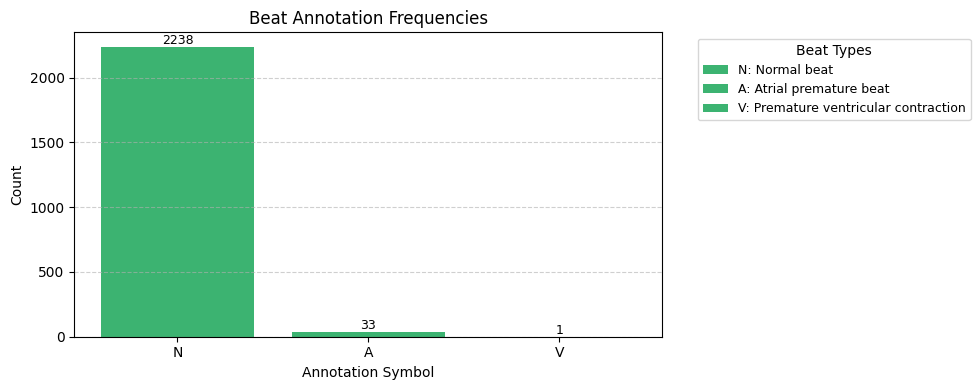

In [7]:
label_counts = Counter(labels)

plot_label_distribution(label_counts, title = "Beat Annotation Frequencies")

## Principal Component Analysis (PCA)

PCA provides a fast, linear, and interpretable way to visualize beat structure and overlap. 